<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Модели-ARIMA" data-toc-modified-id="Модели-ARIMA-1">Модели ARIMA</a></span><ul class="toc-item"><li><span><a href="#Задание" data-toc-modified-id="Задание-1.1">Задание</a></span></li><li><span><a href="#ARIMA-(p,d,q)" data-toc-modified-id="ARIMA-(p,d,q)-1.2">ARIMA (p,d,q)</a></span></li><li><span><a href="#Прогноз-временного-ряда-классическим-ML" data-toc-modified-id="Прогноз-временного-ряда-классическим-ML-1.3">Прогноз временного ряда классическим ML</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Оценка-моделей" data-toc-modified-id="Оценка-моделей-1.3.0.1">Оценка моделей</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Модели ARIMA

## Задание

Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
import statsmodels
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

import warnings

warnings.filterwarnings('ignore')



C:\Users\bauhb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\bauhb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
statsmodels.__version__

'0.12.2'

In [3]:
series = pd.read_csv('Series/weekly-closings-of-the-dowjones-.csv')['Close']

In [4]:
# Dickey-Fuller Test на стационарность ряда

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
# Визуализация

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


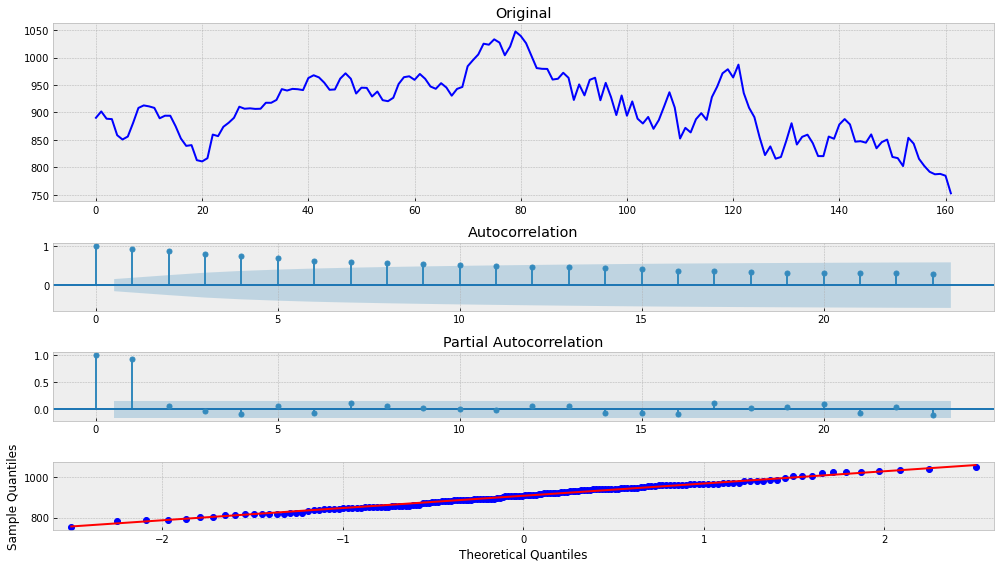

In [6]:
tsplot(series)

## ARIMA (p,d,q)

ARIMA - расширение модели ARMA. Многие временные ряды нестационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) включено в саму модель.


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

best_aic: 1419.41511 | best_order: (0, 2, 1)
Results of Dickey-Fuller Test:
Test Statistic                -1.297237e+01
p-value                        3.062128e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


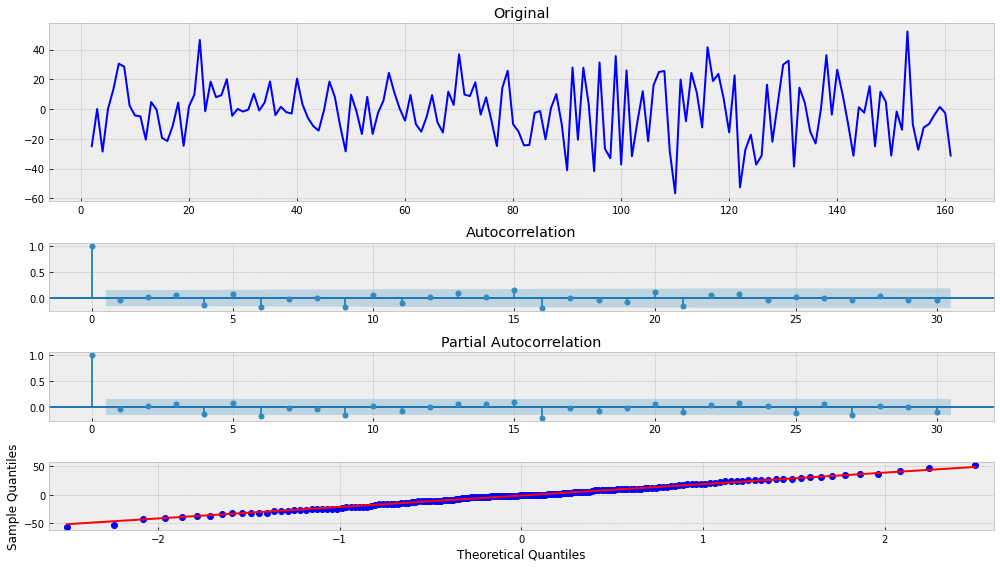

In [7]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5): # p
    for d in range(5): # d
        for j in range(5): # q
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
#                 print(f'aic: {tmp_aic:6.5f} | order: {(i, d, j)}')
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print(f'best_aic: {best_aic:.5f} | best_order: {best_order}')


tsplot(best_mdl.resid, lags=30)

In [8]:
print(best_mdl.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  160
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -707.708
Method:                           mle   S.D. of innovations             19.892
Date:                Wed, 09 Feb 2022   AIC                           1419.415
Time:                        17:40:25   BIC                           1425.565
Sample:                             2   HQIC                          1421.913
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ma.L1.D2.Close    -0.9956      0.048    -20.533      0.000      -1.091      -0.901
                                    Roots                                    
                  Real          Imaginary

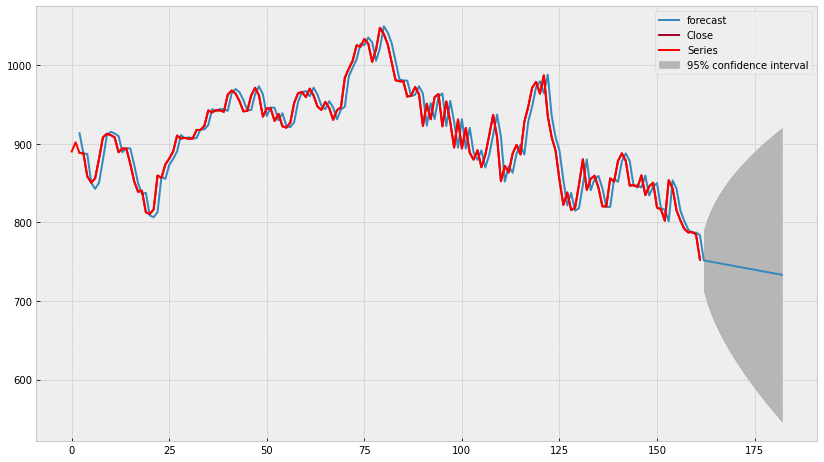

In [9]:
n_pred = 20

with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(best_order[1], len(series)+n_pred, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()

In [10]:
# The mean squared error

y_test = series

y_pred = best_mdl.predict(best_order[1])

print(f'Mean squared error: {mean_squared_error(y_test[2:], y_pred):.4f}')

Mean squared error: 826574.4101


## Прогноз временного ряда классическим ML

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
import re 

In [12]:
ts = pd.read_csv('Series/weekly-closings-of-the-dowjones-.csv')

In [13]:
ts.head(20)

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43
5,1971-W32,850.61
6,1971-W33,856.02
7,1971-W34,880.91
8,1971-W35,908.15
9,1971-W36,912.75


In [14]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Week    162 non-null    object 
 1   Close   162 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.7+ KB


In [15]:
def prepare_data(data, start_lag, end_lag, test_size = 0.15):
    
    data = pd.DataFrame(data.copy())
    
    # добавляем лаги в качестве признаков        
    for i in range(start_lag, end_lag):
        data[f'lag {i}'] = data.Close.shift(i)
    
    data['week_n'] = data['Week'].str.extract(r'(\d{2}$)') #.apply(pd.to_numeric)
    data['year_n'] = data['Week'].str.extract(r'(\d{4})') #.apply(pd.to_numeric)
    
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(['Week'], axis=1)
    data = pd.get_dummies(data)
    
    # разбиваем на train/test
    test_index = int(len(data)*(1-test_size))
    X_train = data.loc[:test_index].drop(['Close'], axis=1)
    y_train = data.loc[:test_index]['Close']
    X_test = data.loc[test_index:].drop(['Close'], axis=1)
    y_test = data.loc[test_index:]['Close']
    
    return X_train, X_test, y_train, y_test


In [16]:
X_train, X_test, y_train, y_test = prepare_data(ts, start_lag=1, end_lag=20, test_size = 0.15)

In [17]:
X_train.shape

(122, 75)

In [18]:
X_test.shape

(22, 75)

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# The coefficients
print(f'Coefficients: {lr.coef_} \n')
# The mean squared error
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.4f}')


Coefficients: [ 9.24385579e-01  7.48039822e-02  1.27317837e-01 -2.60028164e-01
  6.57620237e-02 -1.12118727e-01  9.28356715e-02  7.54901828e-02
 -3.90515316e-01  3.98734940e-01 -3.46892425e-02  5.56473427e-02
 -4.21073658e-02 -8.55827591e-02  2.55237695e-02 -4.80093300e-02
  1.48211316e-01 -3.22360261e-01  2.68116657e-01 -1.67811842e+11
 -1.67811842e+11 -1.67811843e+11 -1.67811842e+11 -1.67811842e+11
 -1.67811842e+11 -1.67811842e+11 -1.67811842e+11 -1.67811842e+11
 -1.67811842e+11 -1.67811842e+11 -1.67811842e+11 -1.67811843e+11
 -1.67811842e+11 -1.67811842e+11 -1.67811842e+11 -1.67811842e+11
 -1.67811843e+11 -1.67811842e+11 -1.67811842e+11 -1.67811842e+11
 -1.67811842e+11 -1.67811843e+11 -1.67811842e+11 -1.67811842e+11
 -1.67811842e+11 -1.67811843e+11 -1.67811842e+11 -1.67811842e+11
 -1.67811842e+11 -1.67811842e+11 -1.67811842e+11 -1.67811843e+11
 -1.67811842e+11 -1.67811842e+11 -1.67811842e+11 -1.67811842e+11
 -1.67811843e+11 -1.67811842e+11 -1.67811842e+11 -1.67811842e+11
 -1.6781184

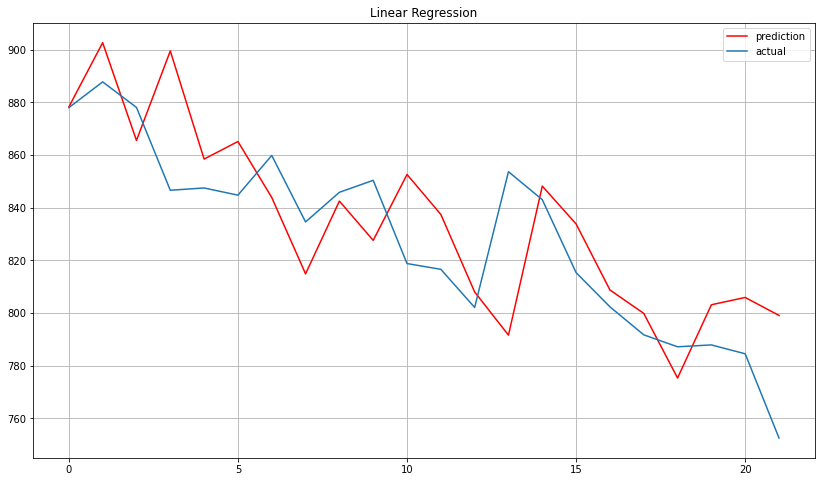

In [20]:
plt.figure(figsize=(14,8))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.reset_index(drop=True), label='actual')
plt.legend()
plt.title('Linear Regression')
plt.grid(True)

#### Оценка моделей


|Модель|Mean squared error|
|:----|:----|
|Модель ARIMA|826574.4101|
|Модель LinearRegression|628.4714|